# Analysing training dynamics using HSIC Criterion

This notebook explains how we can analyse training process by using calculating HSIC criterion as measure of dependence between hidden representation and output label (generalization) and between hidden representation and input variable (complexity) and obtaining 2-D training trajectory in information plane (we will continue calling it information plane even though HSIC criterion has no counter part in information theory).  

## Importing glow modules

In [2]:
# importing PyGlow modules
import glow
from glow.layers import Dense, Dropout, Conv2d, Flatten
from glow.datasets import mnist, cifar10
from glow.models import IBSequential
from glow.information_bottleneck.estimator import HSIC

## Load dataset

In [3]:
# hyperparameter
batch_size = 64
num_workers = 3
validation_split = 0.2
num_epochs = 7

# load the dataset
train_loader, val_loader, test_loader = mnist.load_data(
    batch_size=batch_size, num_workers=num_workers, validation_split=validation_split
)

## IB based Sequential Model - IBSequential
IBSequential is keras like Sequential model with extended functionalities which support tracking of training dynamics using evaluators (instances of glow.information_bottleneck.Estimator). It evaluates the dynamics using criterion defined in the evaluator and obtain 2-D information plane coordinates (x-axis - complexity and y-axis - generalization).

In [4]:
model = IBSequential(input_shape=(1, 28, 28), gpu=True, track_dynamics=True, save_dynamics=True)
model.add(Conv2d(filters=16, kernel_size=3, stride=1, padding=1, activation='relu'))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(10, activation='softmax'))

Running on CUDA enabled device !


## Attaching dynamics evaluator to the model
Attaching HSIC evaluator to the model. You can also use your custom criterion for evaluating the training dynamics (to know how refer Custom_criterion_class.ipynb notebook).

In [5]:
# compile the model
model.compile(optimizer='SGD', loss='cross_entropy', metrics=['accuracy'])
model.attach_evaluator(HSIC(kernel='gaussian', gpu=True, sigma=5))

## Training the model

In [6]:
# train the model along with calculating dynamics
model.fit_generator(train_loader, val_loader, num_epochs)

  0%|          | 0/750 [00:00<?, ?it/s]



Epoch 1/7
Training loop: 


  0%|          | 0/188 [00:00<?, ?it/s]



loss: 2.29 - acc: 0.30
Validation loop: 


  0%|          | 0/750 [00:00<?, ?it/s]



loss: 2.24 - acc: 0.22


Epoch 2/7
Training loop: 


  0%|          | 0/188 [00:00<?, ?it/s]



loss: 1.97 - acc: 0.72
Validation loop: 


  0%|          | 0/750 [00:00<?, ?it/s]



loss: 1.77 - acc: 0.59


Epoch 3/7
Training loop: 


  0%|          | 0/188 [00:00<?, ?it/s]



loss: 1.71 - acc: 0.83
Validation loop: 


  0%|          | 0/750 [00:00<?, ?it/s]



loss: 1.67 - acc: 0.88


Epoch 4/7
Training loop: 


  0%|          | 0/188 [00:00<?, ?it/s]



loss: 1.60 - acc: 0.88
Validation loop: 


  0%|          | 0/750 [00:00<?, ?it/s]



loss: 1.58 - acc: 0.94


Epoch 5/7
Training loop: 


  0%|          | 0/188 [00:00<?, ?it/s]



loss: 1.57 - acc: 0.91
Validation loop: 


  0%|          | 0/750 [00:00<?, ?it/s]



loss: 1.56 - acc: 0.88


Epoch 6/7
Training loop: 


  0%|          | 0/188 [00:00<?, ?it/s]



loss: 1.56 - acc: 0.91
Validation loop: 


  0%|          | 0/750 [00:00<?, ?it/s]



loss: 1.56 - acc: 0.84


Epoch 7/7
Training loop: 


  0%|          | 0/188 [00:00<?, ?it/s]



loss: 1.55 - acc: 0.92
Validation loop: 


100%|██████████| 188/188 [00:02<00:00, 68.21it/s]




loss: 1.57 - acc: 0.81


## Evaluated Dynamics
The evaluated dynamics is a numpy array with shape (N, E, L, 2) where:
- N: Number of epochs
- E: Number of evaluators attached
- L: Number of layers (which have parameters - Dropout and Flatten not included)

Last dimension is 2 because it represents 2-D coordinates (calculated using criterion used) in information plane.

In [9]:
import numpy as np

evaluated_dynamics = np.mean((model.evaluated_dynamics), 1)  # averaged over batches
print(evaluated_dynamics.shape)

(7, 1, 5, 2)


## Plotting calculated coordinates on information plane

layer no. : 1


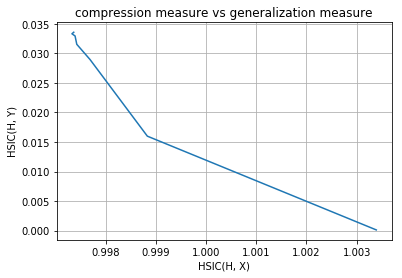

layer no. : 2


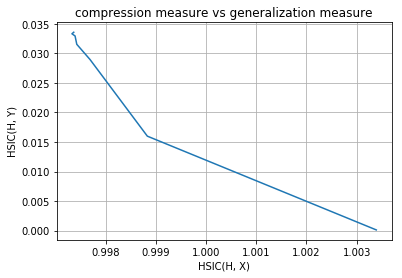

layer no. : 3


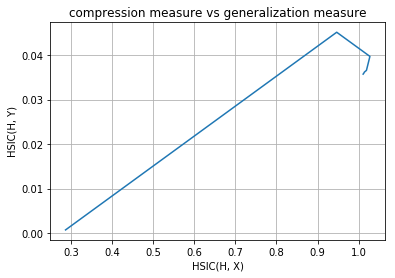

layer no. : 4


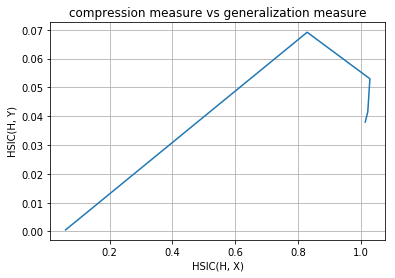

layer no. : 5


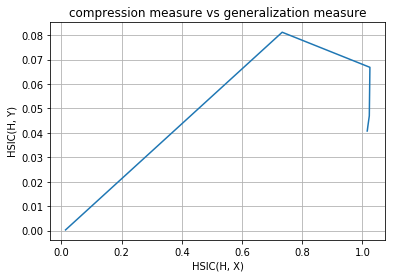

In [14]:
import matplotlib.pyplot as plt

for evaluator_idx in range(1):
    for layer_idx in range(model.num_layers-1):
        print("layer no. :", layer_idx + 1)
        I_x_axis = []
        I_y_axis = []
        for epoch in range(num_epochs):
            I_x = evaluated_dynamics[epoch][evaluator_idx][layer_idx][0].item()
            I_y = evaluated_dynamics[epoch][evaluator_idx][layer_idx][1].item()
            I_x_axis.append(I_x)
            I_y_axis.append(I_y)
            
        plt.title("compression measure vs generalization measure")
        plt.xlabel("HSIC(H, X)")
        plt.ylabel("HSIC(H, Y)")
        plt.grid(True)
        plt.plot(I_x_axis, I_y_axis)
        plt.show()
        
# NOTE: Epochs is increasing from bottom to upward in the plots.

## Inference
As you can observe that initial layers immediately start increasing HSIC(H, Y) and at the same time, decreases HSIC(H, X) (decrease the complexity of representation) but later layers have two phase training in which it first generalizes rapidly at the cost of increasing complexity of representation (generalization phase) but then after aquiring enough generalization abilities it tries to compress the representation and thus decrease the complexity (compression phase). These observations are given in Tishby's paper [Opening the black box of Deep Neural Networks via Information](https://arxiv.org/abs/1703.00810). This paper used mutual information as the dependence criterion but in this notebook we have used HSIC criterion to obtain the information plane trajectories.

Our model is first increasing both the measures and then it is further increasing complexity of representation with decreasing the generalization ability and this is expected as no regularization is used in training the model. Now following is the same plots of HSIC(H, X) and HSIC(H, Y) vs epochs which will make things more clear.

layer no. : 1


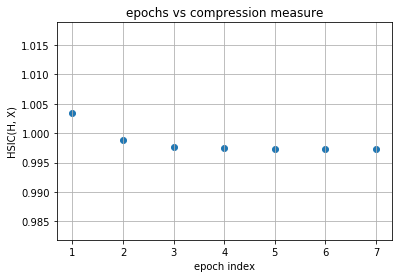

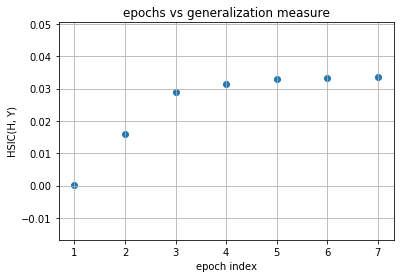

layer no. : 2


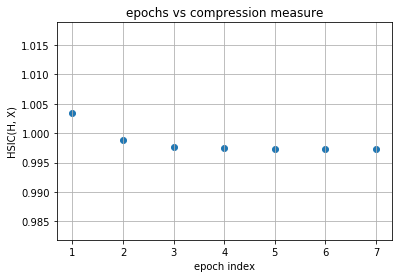

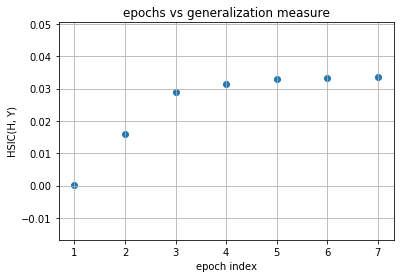

layer no. : 3


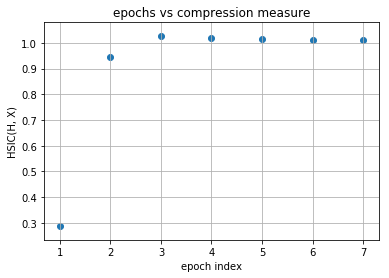

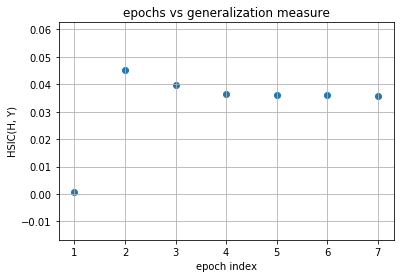

layer no. : 4


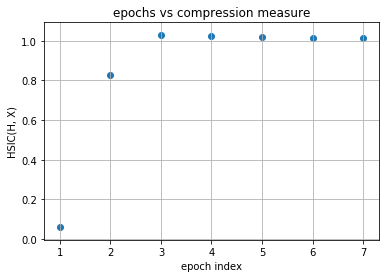

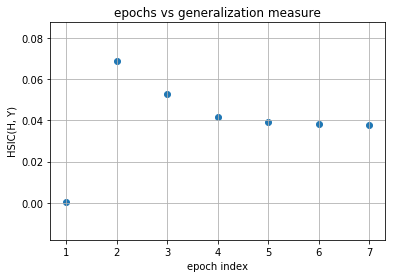

layer no. : 5


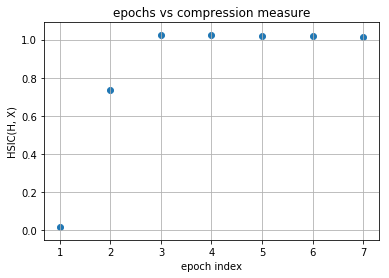

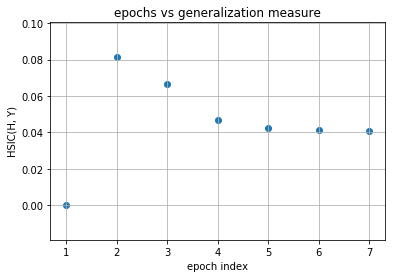

In [12]:
for evaluator_idx in range(1):
    for layer_idx in range(model.num_layers-1):
        print("layer no. :", layer_idx + 1)
        epoch_axis = []
        I_x_axis = []
        I_y_axis = []
        for epoch in range(num_epochs):
            I_x = evaluated_dynamics[epoch][evaluator_idx][layer_idx][0].item()
            I_y = evaluated_dynamics[epoch][evaluator_idx][layer_idx][1].item()
            epoch_axis.append(epoch + 1)
            I_x_axis.append(I_x)
            I_y_axis.append(I_y)
            
        plt.title("epochs vs compression measure")
        plt.xlabel("epoch index")
        plt.ylabel("HSIC(H, X)")
        plt.grid(True)
        plt.scatter(epoch_axis, I_x_axis)
        plt.show()
        
        plt.title("epochs vs generalization measure")
        plt.xlabel("epoch index")
        plt.ylabel("HSIC(H, Y)")
        plt.grid(True)
        plt.scatter(epoch_axis, I_y_axis)
        plt.show()

## Observations
As you can observe for later layers, compression is increasing (complexity of representation is increasing) along with decrement in generalization abilities. This tells us that standard loss functions used for training deep neural networks without regularization is not sufficient to capture the optimality of intermediate representations which in turn governs the generalization ability of the model (optimal trajectory in information plane according to IB-theory). 

* Note that here we have not used any external regularization technique to train the network (no dropout used). 

## Future work
You can now try using some regularization like dropout and observe the information plane trajectory. You can further change your dependence criterion itself and again obtain the trajectories. You can infer from that how different changes are affecting generalization and compression ability of model.